# **ROBUST MULTI-CRITERIA DECISION MAKING**

# **Prerequisites**

In [ ]:
! pip install --pre -U pymoo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 KB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210096 sha256=2e369e358e6fe42ebc9ce7658aff04320a626b4eb231ae0a81bd5de673de8ec5
  Stored in directory: /root/.cache/pip/wheels/2d/08/6b/126ea9009f7482fd53a78d0db2ece5aca70af8f4a30445386b
Successfully built grapheme


In [ ]:
import numpy as np
import math as ma
import scipy
import random
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.rnsga2 import RNSGA2
from pymoo.algorithms.moo.rnsga3 import RNSGA3
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.core.problem import ElementwiseProblem
from pymoo.factory import get_problem, get_reference_directions
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from scipy.stats import qmc
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.problems import get_problem
from pymoo.optimize import minimize

# **4 bar truss problem**

In [ ]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=4,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([1, 2**0.5, 2**0.5, 1]),
                         xu=np.array([3, 3, 3, 3]))

    def _evaluate(self, x, out, *args, **kwargs):
        F = 10; E = 200000; L = 200; S = 10; a = F/S;
        f1 = L*(2*x[0]+ (2**0.5)*x[1] + x[2]**0.5 + x[3])
        f2 = (2*F*L/E)*(1/x[0] + (2**0.5)/x[1] - (2**0.5)/x[2] + 1/x[3])
        out["F"] = [f1, f2]
problem = MyProblem()

In [ ]:
# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=200)

# create the algorithm object
algorithm = NSGA3(pop_size=301, ref_dirs=ref_dirs)
#algorithm = NSGA2(pop_size=1000)
res = minimize(problem,
               algorithm,
               ("n_gen", 200),
               verbose=True,
               seed=1)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      301 |     14 |             - |             -
     2 |      602 |     19 |  0.0235149444 |             f
     3 |      903 |     28 |  0.0217718078 |         ideal
     4 |     1204 |     34 |  0.0158851606 |             f
     5 |     1505 |     34 |  0.0194557242 |         ideal
     6 |     1806 |     51 |  0.0071724916 |         ideal
     7 |     2107 |     58 |  0.0276123583 |         ideal
     8 |     2408 |     69 |  0.0079588471 |         ideal
     9 |     2709 |     89 |  0.0161694219 |         ideal
    10 |     3010 |    106 |  0.0040845038 |             f
    11 |     3311 |    115 |  0.0131622434 |         ideal
    12 |     3612 |    172 |  0.0025950384 |             f
    13 |     3913 |    174 |  0.0187590531 |         ideal
    14 |     4214 |    177 |  0.0006213880 |             f
    15 |     4515 |    181 |  0.0016348631 |             f
    16 |     4816 |    187 |  0.0020666077 |            

## **Robust Multi-Criteria Decision Making**

### **MCDM A: NSGA-III $\rightarrow$ MCDM $\rightarrow$ Robustness**

In [ ]:
# Define reference points
ref_points = np.array([[1500, 0.04], [2000, 0.035], [2500, 0.02]])

algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=20,
    mu=0.05)

res_RNSGAIIIa = minimize(problem,
               algorithm=algorithm,
               termination=('n_gen', 200),
               extreme_points_as_reference_points=False,
               seed=10, pf = res.F,
               verbose=False)

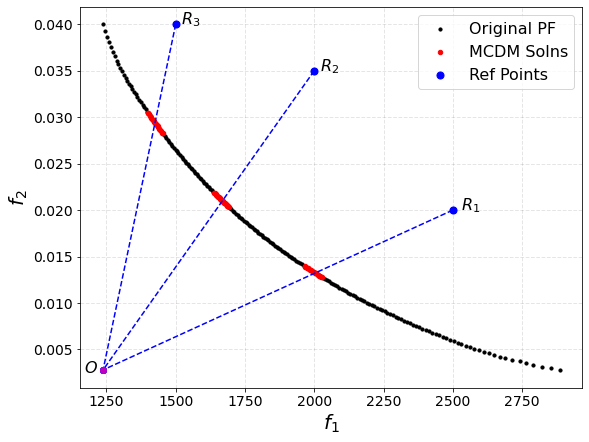

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(9, 7))
plt.rcParams['font.size'] = 14

res_RNSGAIIIa.F = res_RNSGAIIIa.F[res_RNSGAIIIa.F[:,1]<0.0399]
res_RNSGAIIIa.F = res_RNSGAIIIa.F[res_RNSGAIIIa.F[:,0]<2750]

plt.scatter(res.F[:, 0], res.F[:, 1], s=10, facecolors='k', edgecolors='k')
plt.scatter(res_RNSGAIIIa.F[:, 0], res_RNSGAIIIa.F[:, 1], s=20, facecolors='r', edgecolors='r')
plt.scatter(ref_points[:, 0], ref_points[:, 1], s=50, facecolors='b', edgecolors='b')
plt.legend(["Original PF", "MCDM Solns", "Ref Points"], loc ="upper right",fontsize=16) #"Deterministic",   "beta = 3.5",

plt.plot([2500, 1237.84], [0.02, 0.0028], 'bo', linestyle="--") # 1237.8414230005442, 0.0027614237491539674
plt.plot([2000, 1237.84], [0.035, 0.0028], 'bo', linestyle="--")
plt.plot([1500, 1237.84], [0.04, 0.0028], 'bo', linestyle="--")
plt.plot([1237.84], [0.0028], 'mo', linestyle="--")
plt.text(2530, 0.02, "$R_1$", fontsize=16)
plt.text(2020, 0.035, "$R_2$", fontsize=16)
plt.text(1520, 0.04, "$R_3$", fontsize=16)
plt.text(1170, 0.0025, "$O$", fontsize=16)

plt.xlabel('$f_1$',fontsize=20)
plt.ylabel('$f_2$',fontsize=20)
#plt.title("MCDM without robustness definition",fontsize=20)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.1)
plt.show()

### **Mean Effective Function**

In [ ]:
def Eff_Truss_obj1(x):                                                                            # Objective function 1
  F = 10; E = 200000; L = 200; S = 10;
  delta = 0.25
  lb = x - [2*delta, 2*delta, delta, 2*delta]
  ub = x + [2*delta, 2*delta, delta, 2*delta]
  sampler = qmc.LatinHypercube(d=4)
  sample = sampler.random(n=500)
  xe = qmc.scale(sample, lb, ub)
  return np.mean(L*(2*xe[:,0] + (2**0.5)*xe[:,1] + xe[:,2]**0.5 + xe[:,3]))

def Eff_Truss_obj2(x):                                                                            # Objective function 2
  F = 10; E = 200000; L = 200; S = 10;
  delta = 0.25
  lb = x - [2*delta, 2*delta, delta, 2*delta]
  ub = x + [2*delta, 2*delta, delta, 2*delta]
  sampler = qmc.LatinHypercube(d=4)
  sample = sampler.random(n=500)
  xe = qmc.scale(sample, lb, ub)
  return np.mean((2*F*L/E)*(1/xe[:,0] + (2**0.5)/xe[:,1] - (2**0.5)/xe[:,2] + 1/xe[:,3]))

### **Robusteness Check for MCDM Solns**

In [ ]:
F, G = problem1.evaluate(res_RNSGAIIIa.X)
F_Rob_a = F[G[:,0]<0]
#print(F_Rob_a)

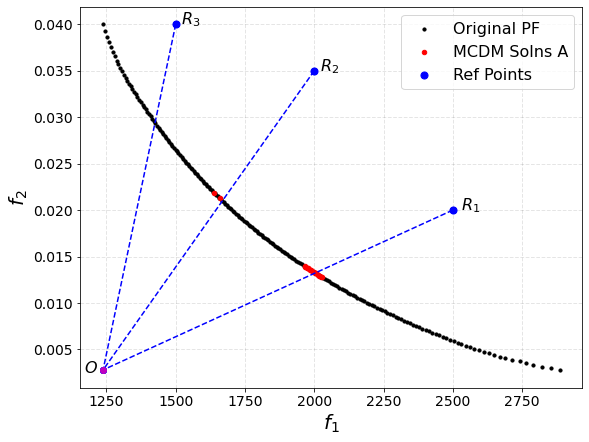

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 7))
plt.rcParams['font.size'] = 14

#F_Rob_a = F_Rob_a[F_Rob_a[:,1]<0.99]
F_Rob_a = F_Rob_a[F_Rob_a[:,0]<2750]

plt.scatter(res.F[:, 0], res.F[:, 1], s=10, facecolors='k', edgecolors='k')
plt.scatter(F_Rob_a[:, 0], F_Rob_a[:, 1], s=20, facecolors='r', edgecolors='r')
plt.scatter(ref_points[:, 0], ref_points[:, 1], s=50, facecolors='b', edgecolors='b')
plt.legend(["Original PF", "MCDM Solns A", "Ref Points", "Line A", "Line B"], loc ="upper right",fontsize=16) #"Deterministic",   "beta = 3.5",

plt.plot([2500, 1237.84], [0.02, 0.0028], 'bo', linestyle="--") # 1237.8414230005442, 0.0027614237491539674
plt.plot([2000, 1237.84], [0.035, 0.0028], 'bo', linestyle="--")
plt.plot([1500, 1237.84], [0.04, 0.0028], 'bo', linestyle="--")
plt.plot([1237.84], [0.0028], 'mo', linestyle="--")
plt.text(2530, 0.02, "$R_1$", fontsize=16)
plt.text(2020, 0.035, "$R_2$", fontsize=16)
plt.text(1520, 0.04, "$R_3$", fontsize=16)
plt.text(1170, 0.0025, "$O$", fontsize=16)


plt.xlabel('$f_1$',fontsize=20)
plt.ylabel('$f_2$',fontsize=20)

#plt.title("NSGA-III $\Rightarrow$ MCDM $\Rightarrow$ Robustness",fontsize=20)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.1)
plt.show()

### **MCDM B: NSGA-III  $\rightarrow$ Robustness $\rightarrow$ MCDM**

### **Robustness Check of Original PF**

In [ ]:
F_b, G_b = problem1.evaluate(res.X)
F_Rob_b = F_b[G_b[:,0]<0]
#print(F_Rob_b)

In [ ]:
ref_points = np.array([[1500, 0.04], [2000, 0.035], [2500, 0.02]])
p2 = [1237.84, 0.0028]
p1 = [2000, 0.04]

import numpy as np
p1=np.array([0,0])
p2=np.array([10,10])
p3=np.array([5,7])
d=abs(np.cross(p2-p1,F_Rob_b-p1)/np.linalg.norm(p2-p1))

In [ ]:
T_10 = sorted(d)[-10:]

In [ ]:
Pref_sol = np.zeros([10,2])
for i in range (0, 10):
  a=[]
  a = F_Rob_b[T_10[i] == d, :]
#  print(a[0])
  Pref_sol[i] = a[0]

In [ ]:
# Define reference points
ref_points = np.array([[1500, 0.04], [2000, 0.035], [2500, 0.02]])

algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=20,
    mu=0.05)

res_RNSGAIIIb = minimize(problem,
               algorithm=algorithm,
               termination=('n_gen', 200),
               extreme_points_as_reference_points=True,
               seed=10, pf = F_Rob_b,
               verbose=False)

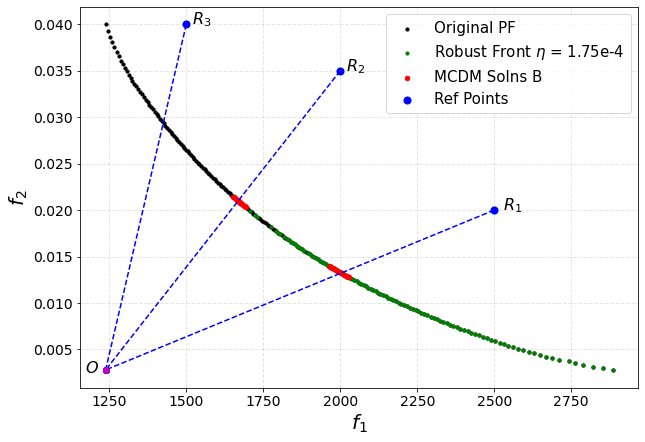

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.rcParams['font.size'] = 14

res_RNSGAIIIb.F = res_RNSGAIIIb.F[res_RNSGAIIIb.F[:,1]<0.0215]
res_RNSGAIIIb.F = res_RNSGAIIIb.F[res_RNSGAIIIb.F[:,0]<2750]

plt.scatter(res.F[:, 0], res.F[:, 1], s=10, facecolors='k', edgecolors='k')
plt.scatter(F_Rob_b[:, 0], F_Rob_b[:, 1], s=10, facecolors='g', edgecolors='g')
plt.scatter(res_RNSGAIIIb.F[:, 0], res_RNSGAIIIb.F[:, 1], s=20, facecolors='r', edgecolors='r')
plt.scatter(ref_points[:, 0], ref_points[:, 1], s=50, facecolors='b', edgecolors='b')
plt.legend(["Original PF", "Robust Front $\eta$ = 1.75e-4", "MCDM Solns B", "Ref Points", "Line A", "Line B"], loc ="upper right",fontsize=15) #"Deterministic",   "beta = 3.5",

plt.plot([2500, 1237.84], [0.02, 0.0028], 'bo', linestyle="--") # 1237.8414230005442, 0.0027614237491539674
plt.plot([2000, 1237.84], [0.035, 0.0028], 'bo', linestyle="--")
plt.plot([1500, 1237.84], [0.04, 0.0028], 'bo', linestyle="--")
plt.plot([1237.84], [0.0028], 'mo', linestyle="--")
plt.text(2530, 0.02, "$R_1$", fontsize=16)
plt.text(2020, 0.035, "$R_2$", fontsize=16)
plt.text(1520, 0.04, "$R_3$", fontsize=16)
plt.text(1170, 0.0025, "$O$", fontsize=16)


plt.xlabel('$f_1$',fontsize=20)
plt.ylabel('$f_2$',fontsize=20)

#plt.title("NSGA-III $\Rightarrow$ Robustness $\Rightarrow$ MCDM",fontsize=20)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.1)
plt.show()

### **R-NSGA-III based MCDM**

In [ ]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=4,
                         n_obj=2,
                         n_constr=1,
                         xl=np.array([1, 2**0.5, 2**0.5, 1]),
                         xu=np.array([3, 3, 3, 3]))

    def _evaluate(self, x, out, *args, **kwargs):
        F = 10; E = 200000; L = 200; S = 10; a = F/S;
        f1 = L*(2*x[0]+ (2**0.5)*x[1] + x[2]**0.5 + x[3])
        f2 = (2*F*L/E)*(1/x[0] + (2**0.5)/x[1] - (2**0.5)/x[2] +1/x[3])

        f1_e = np.mean(Eff_Truss_obj1(x))
        f2_e = np.mean(Eff_Truss_obj2(x))

        g1 = np.linalg.norm(np.array([f1,f2])-np.array([f1_e,f2_e]))/np.linalg.norm(np.array([f1,f2])) -  0.000175
        out["F"] = [f1, f2]
        out["G"] = [g1]
problem1 = MyProblem()

In [ ]:
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=300)

# create the algorithm object
algorithm = NSGA3(pop_size=301, ref_dirs=ref_dirs)
#algorithm = NSGA2(pop_size=201)
res_Rob = minimize(problem1,
               algorithm,
               ("n_gen", 500),
               verbose=True,
               seed=1)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      301 |     15 |  0.000000E+00 |  4.931207E-07 |             - |             -
     2 |      602 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0311907556 |             f
     3 |      903 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0175967775 |             f
     4 |     1204 |     38 |  0.000000E+00 |  0.000000E+00 |  0.0416461384 |         ideal
     5 |     1505 |     46 |  0.000000E+00 |  0.000000E+00 |  0.0162404144 |         ideal
     6 |     1806 |     38 |  0.000000E+00 |  0.000000E+00 |  0.0033555171 |         ideal
     7 |     2107 |     56 |  0.000000E+00 |  0.000000E+00 |  0.0063041002 |         ideal
     8 |     2408 |     75 |  0.000000E+00 |  0.000000E+00 |  0.0077930873 |             f
     9 |     2709 |     76 |  0.000000E+00 |  0.000000E+00 |  0.0133166364 |         ideal
    10 |     3010 |     93 |  0.000000E+00 |  0.000000E+00 |  0.0060835075 |         ideal

### **MCDM C: Robust NSGA-III $\rightarrow$ MCDM**

In [ ]:
# Define reference points
ref_points = np.array([[1500, 0.04], [2000, 0.035], [2500, 0.02]])

algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=20,
    mu=0.05)

res_RNSGAIIIc = minimize(problem1,
               algorithm=algorithm,
               termination=('n_gen', 1000),
               extreme_points_as_reference_points=True,
               seed=10, pf = res_Rob.F,
               verbose=False)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#plt.rcParams['font.size'] = 14

res_RNSGAIIIc.F = res_RNSGAIIIc.F[res_RNSGAIIIc.F[:,1]<0.04]
res_RNSGAIIIc.F = res_RNSGAIIIc.F[res_RNSGAIIIc.F[:,0]<2750]

plt.scatter(res.F[:, 0], res.F[:, 1], s=10, facecolors='k', edgecolors='k')
plt.scatter(res_Rob.F[:, 0], res_Rob.F[:, 1], s=10, facecolors='g', edgecolors='g')
plt.scatter(res_RNSGAIIIc.F[:, 0], res_RNSGAIIIc.F[:, 1], s=20, facecolors='r', edgecolors='r')
plt.scatter(ref_points[:, 0], ref_points[:, 1], s=50, facecolors='b', edgecolors='b')
plt.legend(["Original PF","Robust front $\eta$ = 1.75e-4", "MCDM Solns C", "Ref Points"], loc ="upper right",fontsize=16) #"Deterministic",   "beta = 3.5",

plt.plot([2500, 1237.84], [0.02, 0.0028], 'bo', linestyle="--") # 1237.8414230005442, 0.0027614237491539674
plt.plot([2000, 1237.84], [0.035, 0.0028], 'bo', linestyle="--")
plt.plot([1500, 1237.84], [0.04, 0.0028], 'bo', linestyle="--")
plt.plot([1237.84], [0.0028], 'mo', linestyle="--")
plt.text(2530, 0.02, "$R_1$", fontsize=16)
plt.text(2020, 0.035, "$R_2$", fontsize=16)
plt.text(1520, 0.04, "$R_3$", fontsize=16)
plt.text(1170, 0.0025, "$O$", fontsize=16)

plt.xlabel('$f_1$',fontsize=20)
plt.ylabel('$f_2$',fontsize=20)
#plt.title("Robust NSGA-III $\Rightarrow$ MCDM",fontsize=20)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.1)
plt.show()

### **MCDM D: Robust R-NSGA-III**

In [ ]:
# Define reference points
ref_points = np.array([[1500, 0.04], [2000, 0.035], [2500, 0.02]])

algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=20,
    mu=0.05)

res_RNSGAIIId = minimize(problem1,
               algorithm=algorithm,
               termination=('n_gen', 1000),
               extreme_points_as_reference_points=True,
               seed=10,
               verbose=False)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 7))
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# matplotlib.rcParams['text.usetex'] = True

res_RNSGAIIId.F = res_RNSGAIIId.F[res_RNSGAIIId.F[:,1]<0.039]
res_RNSGAIIId.F = res_RNSGAIIId.F[res_RNSGAIIId.F[:,0]<2750]

plt.scatter(res.F[:, 0], res.F[:, 1], s=10, facecolors='k', edgecolors='k')
# plt.scatter(res_Rob.F[:, 0], res_Rob.F[:, 1], s=10, facecolors='g', edgecolors='g')
plt.scatter(res_RNSGAIIId.F[:, 0], res_RNSGAIIId.F[:, 1], s=20, facecolors='r', edgecolors='r')
plt.scatter(ref_points[:, 0], ref_points[:, 1], s=50, facecolors='b', edgecolors='b')
plt.legend(["Original PF","MCDM Solns D", "Ref Points"], loc ="upper right",fontsize=16) #"Deterministic",   "beta = 3.5",

plt.plot([2500, 1237.84], [0.02, 0.0028], 'bo', linestyle="--") # 1237.8414230005442, 0.0027614237491539674
plt.plot([2000, 1237.84], [0.035, 0.0028], 'bo', linestyle="--")
plt.plot([1500, 1237.84], [0.04, 0.0028], 'bo', linestyle="--")
plt.plot([1237.84], [0.0028], 'mo', linestyle="--")
plt.text(2530, 0.02, "$R_1$", fontsize=16)
plt.text(2020, 0.035, "$R_2$", fontsize=16)
plt.text(1520, 0.04, "$R_3$", fontsize=16)
plt.text(1170, 0.0025, "$O$", fontsize=16)

plt.xlabel('$f_1$',fontsize=20)
plt.ylabel('$f_2$',fontsize=20)

# plt.title("Robust R-NSGA-III",fontsize=20)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.1)
plt.show()

# **2-Objective Test Problem**

In [ ]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=5,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([0, -1, -1, -1, -1]),
                         xu=np.array([1, 1, 1, 1, 1]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[0]
        h = 1-x[0]**2
        g = 40 + x[1]**2 + x[2]**2 + x[3]**2 + x[4]**2 - 10*np.cos(4*ma.pi*x[1]) - 10*np.cos(4*ma.pi*x[2]) - 10*np.cos(4*ma.pi*x[3]) - 10*np.cos(4*ma.pi*x[4])
        S = 1/(0.2 + x[0]) + x[0]**2
        f2 = h + g*S

        out["F"] = [f1, f2]

problem = MyProblem()

In [ ]:
# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=99)

# create the algorithm object
algorithm = NSGA3(pop_size=100, ref_dirs=ref_dirs)

res_act = minimize(problem,
               algorithm,
               ("n_gen", 200),
               verbose=True,
               seed=1)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      5 |             - |             -
     2 |      200 |      8 |  0.0043161564 |         nadir
     3 |      300 |      8 |  0.0557913884 |         ideal
     4 |      400 |      7 |  0.0819958105 |         ideal
     5 |      500 |      4 |  0.0091267342 |         nadir
     6 |      600 |      6 |  0.0155733235 |         ideal
     7 |      700 |      4 |  0.0419610560 |         nadir
     8 |      800 |      6 |  0.0455333692 |         ideal
     9 |      900 |      4 |  0.1029916125 |         nadir
    10 |     1000 |      5 |  0.0578555987 |             f
    11 |     1100 |      5 |  0.0387155112 |         nadir
    12 |     1200 |      8 |  0.0231045069 |         ideal
    13 |     1300 |     10 |  0.2757356222 |         nadir
    14 |     1400 |      8 |  0.2080013494 |         nadir
    15 |     1500 |      8 |  0.1143733051 |         nadir
    16 |     1600 |      7 |  0.0187147776 |            

In [ ]:
len(ref_dirs[:,0])

100

## **Robust Multi-Criteria Decision Making**

### **MCDM A: NSGA-III $\rightarrow$ MCDM $\rightarrow$ Robustness**

In [ ]:
ref_points = np.array([[0.8, 0.9], [0.4, 2.0]]) #

algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=20,
    mu=0.05)

res_RNSGAIIIa = minimize(problem,
               algorithm=algorithm,
               termination=('n_gen', 500),
               extreme_points_as_reference_points=True,
               seed=1, pf = res_act.F,
               verbose=False)

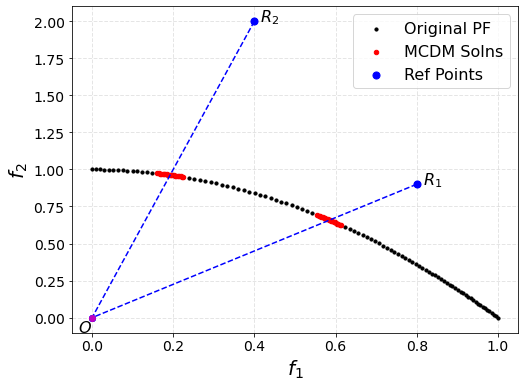

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

res_RNSGAIIIa.F = res_RNSGAIIIa.F[res_RNSGAIIIa.F[:,1]<0.99]
res_RNSGAIIIa.F = res_RNSGAIIIa.F[res_RNSGAIIIa.F[:,0]<0.99]

plt.scatter(res_act.F[:, 0], res_act.F[:, 1], s=10, facecolors='k', edgecolors='k')
plt.scatter(res_RNSGAIIIa.F[:, 0], res_RNSGAIIIa.F[:, 1], s=20, facecolors='r', edgecolors='r')
plt.scatter(ref_points[:, 0], ref_points[:, 1], s=50, facecolors='b', edgecolors='b')
plt.legend(["Original PF", "MCDM Solns", "Ref Points", "Line A", "Line B"], loc ="upper right",fontsize=16) #"Deterministic",   "beta = 3.5",

plt.plot([0.8, 0], [0.9, 0], 'bo', linestyle="--")
plt.plot([0.4,0], [2,0], 'bo', linestyle="--")
plt.plot([0], [0], 'mo', linestyle="--")
plt.text(0.8+0.015, 0.9, "$R_1$",fontsize=16)
plt.text(0.4+0.015, 2.0, "$R_2$",fontsize=16)
plt.text(-0.035, -0.1, "$O$",fontsize=16)



plt.xlabel('$f_1$',fontsize=20)
plt.ylabel('$f_2$',fontsize=20)

#plt.title("MCDM without robustness definition",fontsize=20)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.1)
plt.show()

### **Mean Effective Fucntion**

In [ ]:
def Eff_O2T1_obj1(x):
  delta = 0.007; delta1 = 2*delta; alpha = 1; beta = 1;
  lb = x - [delta, delta1, delta1, delta1, delta1]
  ub = x + [delta, delta1, delta1, delta1, delta1]
  sampler = qmc.LatinHypercube(d=5)
  sample = sampler.random(n=100)
  xe = qmc.scale(sample, lb, ub)
  return np.mean(xe[:,0])

def Eff_O2T1_obj2(x):
  delta = 0.007; delta1 = 2*delta; alpha = 1; beta = 1;
  lb = x - [delta, delta1, delta1, delta1, delta1]
  ub = x + [delta, delta1, delta1, delta1, delta1]
  sampler = qmc.LatinHypercube(d=5)
  sample = sampler.random(n=100)
  xe = qmc.scale(sample, lb, ub)
  h = 1-xe[:,0]**2
  g = 40 + xe[:,1]**2 + xe[:,2]**2 + xe[:,3]**2 + xe[:,4]**2 - 10*np.cos(4*ma.pi*xe[:,1]) - 10*np.cos(4*ma.pi*xe[:,2]) - 10*np.cos(4*ma.pi*xe[:,3]) - 10*np.cos(4*ma.pi*xe[:,4])
  S = alpha/(0.2 + xe[:,0]) + beta*xe[:,0]**2
  return np.mean(h + g*S)

### **Robusteness Check of MCDM Solns**

In [ ]:
F, G = problem1.evaluate(res_RNSGAIIIa.X)
F_Rob_a = F[G[:,0]<0]
#print(F_Rob_a)

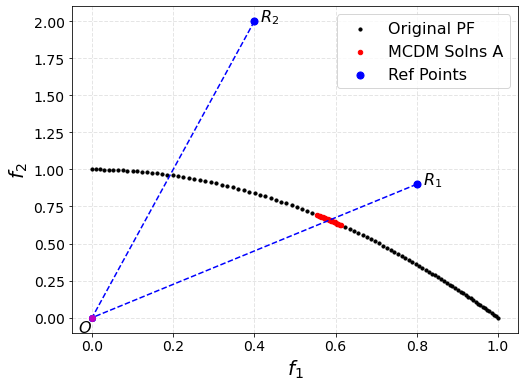

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

F_Rob_a = F_Rob_a[F_Rob_a[:,1]<0.99]
F_Rob_a = F_Rob_a[F_Rob_a[:,0]<0.99]

plt.scatter(res_act.F[:, 0], res_act.F[:, 1], s=10, facecolors='k', edgecolors='k')
plt.scatter(F_Rob_a[:, 0], F_Rob_a[:, 1], s=20, facecolors='r', edgecolors='r')
plt.scatter(ref_points[:, 0], ref_points[:, 1], s=50, facecolors='b', edgecolors='b')
plt.legend(["Original PF", "MCDM Solns A", "Ref Points", "Line A", "Line B"], loc ="upper right",fontsize=16) #"Deterministic",   "beta = 3.5",

plt.plot([0.8, 0], [0.9, 0], 'bo', linestyle="--")
plt.plot([0.4,0], [2,0], 'bo', linestyle="--")
plt.plot([0], [0], 'mo', linestyle="--")
plt.text(0.8+0.015, 0.9, "$R_1$",fontsize=16)
plt.text(0.4+0.015, 2.0, "$R_2$",fontsize=16)
plt.text(-0.035, -0.1, "$O$",fontsize=16)



plt.xlabel('$f_1$',fontsize=20)
plt.ylabel('$f_2$',fontsize=20)

#plt.title("NSGA-III $\Rightarrow$ MCDM $\Rightarrow$ Robustness",fontsize=20)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.1)
plt.show()

### **MCDM B: NSGA-III  $\rightarrow$ Robustness $\rightarrow$ MCDM**

### **Robustness Check of Original PF**

In [ ]:
F_b, G_b = problem1.evaluate(res_act.X)
F_Rob_b = F_b[G_b[:,0]<0]
#print(F_Rob_b)

In [ ]:
ref_points = np.array([[0.8, 0.9], [0.4, 2.0]]) #

algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=20,
    mu=0.05)

res_RNSGAIIIb = minimize(problem1,
               algorithm=algorithm,
               termination=('n_gen', 2000),
               extreme_points_as_reference_points=False,
               seed=1, pf = F_Rob_b,
               verbose=False)

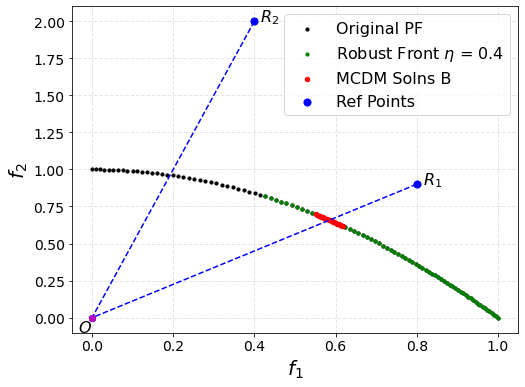

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

res_RNSGAIIIb.F = res_RNSGAIIIb.F[res_RNSGAIIIb.F[:,1]<0.99]
res_RNSGAIIIb.F = res_RNSGAIIIb.F[res_RNSGAIIIb.F[:,0]<0.99]

plt.scatter(res_act.F[:, 0], res_act.F[:, 1], s=10, facecolors='k', edgecolors='k')
plt.scatter(F_Rob_b[:, 0], F_Rob_b[:, 1], s=10, facecolors='g', edgecolors='g')
plt.scatter(res_RNSGAIIIb.F[:, 0], res_RNSGAIIIb.F[:, 1], s=20, facecolors='r', edgecolors='r')
plt.scatter(ref_points[:, 0], ref_points[:, 1], s=50, facecolors='b', edgecolors='b')
plt.legend(["Original PF", "Robust Front $\eta$ = 0.4", "MCDM Solns B", "Ref Points", "Line A", "Line B"], loc ="upper right",fontsize=16) #"Deterministic",   "beta = 3.5",

plt.plot([0.8, 0], [0.9, 0], 'bo', linestyle="--")
plt.plot([0.4,0], [2,0], 'bo', linestyle="--")
plt.plot([0], [0], 'mo', linestyle="--")
plt.text(0.8+0.015, 0.9, "$R_1$",fontsize=16)
plt.text(0.4+0.015, 2.0, "$R_2$",fontsize=16)
plt.text(-0.035, -0.1, "$O$",fontsize=16)



plt.xlabel('$f_1$',fontsize=20)
plt.ylabel('$f_2$',fontsize=20)

# plt.title("NSGA-III $\Rightarrow$ Robust $\Rightarrow$ MCDM",fontsize=20)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.1)
plt.show()

### **R-NSGA-III based MCDM**

In [ ]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=5,
                         n_obj=2,
                         n_constr=1,
                         xl=np.array([0, -1, -1, -1, -1]),
                         xu=np.array([1, 1, 1, 1, 1]))

    def _evaluate(self, x, out, *args, **kwargs):

        f1 = x[0]
        h = 1-x[0]**2
        g = 40 + x[1]**2 + x[2]**2 + x[3]**2 + x[4]**2 - 10*np.cos(4*ma.pi*x[1]) - 10*np.cos(4*ma.pi*x[2]) - 10*np.cos(4*ma.pi*x[3]) - 10*np.cos(4*ma.pi*x[4])
        S = 1/(0.2 + x[0]) + x[0]**2
        f2 = h + g*S

        f1_e = Eff_O2T1_obj1(x)
        f2_e = Eff_O2T1_obj2(x)

        g1 = np.linalg.norm(np.array([f1,f2])-np.array([f1_e,f2_e]))/np.linalg.norm(np.array([f1,f2])) -  0.4

        out["F"] = [f1, f2]
        out["G"] = [g1]

problem1 = MyProblem()

### **MCDM C: Robust NSGA-III $\rightarrow$ MCDM**

In [ ]:
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=200)

# create the algorithm object
algorithm = NSGA3(pop_size=201, ref_dirs=ref_dirs)
res_Rob_c = minimize(problem1,
               algorithm,
               ("n_gen", 200),
               verbose=True,
               seed=1)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      201 |      6 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      402 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0045462711 |         ideal
     3 |      603 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0302206840 |         ideal
     4 |      804 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0744512361 |         nadir
     5 |     1005 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0034309303 |         ideal
     6 |     1206 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0517667645 |         ideal
     7 |     1407 |      7 |  0.000000E+00 |  0.000000E+00 |  5.2109877373 |         nadir
     8 |     1608 |      6 |  0.000000E+00 |  0.000000E+00 |  0.6463820908 |         nadir
     9 |     1809 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0641348953 |             f
    10 |     2010 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0114567253 |         ideal

In [ ]:
ref_points = np.array([[0.8, 0.9], [0.4, 2.0]]) #

algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=10,
    mu=0.05)

res_RNSGAIIIc = minimize(problem1,
               algorithm=algorithm,
               termination=('n_gen', 5000),
               extreme_points_as_reference_points=True,
               seed=1, pf = res_Rob_c.F,
               verbose=False)

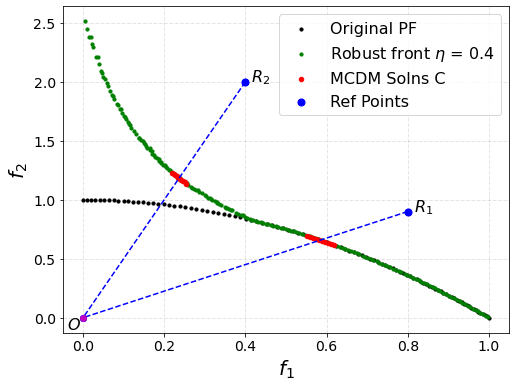

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

res_RNSGAIIIc.F = res_RNSGAIIIc.F[res_RNSGAIIIc.F[:,1]<2]
res_RNSGAIIIc.F = res_RNSGAIIIc.F[res_RNSGAIIIc.F[:,0]<0.9]
res_Rob_c.F = res_Rob_c.F[res_Rob_c.F[:,1]<3]

plt.scatter(res_act.F[:, 0], res_act.F[:, 1], s=10, facecolors='k', edgecolors='k')
plt.scatter(res_Rob_c.F[:, 0], res_Rob_c.F[:, 1], s=10, facecolors='g', edgecolors='g')
plt.scatter(res_RNSGAIIIc.F[:, 0], res_RNSGAIIIc.F[:, 1], s=20, facecolors='r', edgecolors='r')
plt.scatter(ref_points[:, 0], ref_points[:, 1], s=50, facecolors='b', edgecolors='b')
plt.legend(["Original PF","Robust front $\eta$ = 0.4", "MCDM Solns C", "Ref Points", "Line A", "Line B"], loc ="upper right",fontsize=16) #"Deterministic",   "beta = 3.5",

plt.plot([0.8, 0], [0.9, 0], 'bo', linestyle="--")
plt.plot([0.4,0], [2,0], 'bo', linestyle="--")
plt.plot([0], [0], 'mo', linestyle="--")
plt.text(0.8+0.015, 0.9, "$R_1$",fontsize=16)
plt.text(0.4+0.015, 2.0, "$R_2$",fontsize=16)
plt.text(-0.04, -0.1, "$O$",fontsize=16)



plt.xlabel('$f_1$',fontsize=20)
plt.ylabel('$f_2$',fontsize=20)

# plt.title("Robust NSGA-III $\Rightarrow$ MCDM",fontsize=20)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.1)
plt.show()

### **MCDM D: Robust R-NSGA-III**

In [ ]:
ref_points = np.array([[0.8, 0.9], [0.4, 2.0]]) #

algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=10,
    mu=0.05)

res_RNSGAIIId = minimize(problem1,
               algorithm=algorithm,
               termination=('n_gen', 5000),
               extreme_points_as_reference_points=True,
               seed=1,
               verbose=False)

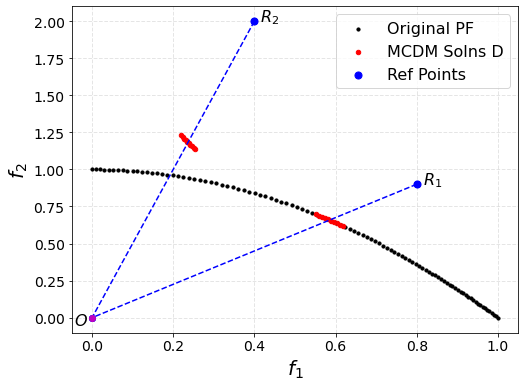

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


res_RNSGAIIId.F = res_RNSGAIIId.F[res_RNSGAIIId.F[:,1]<2]
res_RNSGAIIId.F = res_RNSGAIIId.F[res_RNSGAIIId.F[:,0]<0.9]
#res_Rob.F = res_Rob.F[res_Rob.F[:,1]<3]

plt.scatter(res_act.F[:, 0], res_act.F[:, 1], s=10, facecolors='k', edgecolors='k')
plt.scatter(res_RNSGAIIId.F[:, 0], res_RNSGAIIId.F[:, 1], s=20, facecolors='r', edgecolors='r')
#plt.scatter(res_RNSGAIII.F[:, 0], res_RNSGAIII.F[:, 1], s=20, facecolors='g', edgecolors='g')
plt.scatter(ref_points[:, 0], ref_points[:, 1], s=50, facecolors='b', edgecolors='b')
plt.legend(["Original PF", "MCDM Solns D", "Ref Points", "Line A", "Line B"], loc ="upper right",fontsize=16) #"Deterministic",   "beta = 3.5",

plt.plot([0.8, 0], [0.9, 0], 'bo', linestyle="--")
plt.plot([0.4,0], [2,0], 'bo', linestyle="--")
plt.plot([0], [0], 'mo', linestyle="--")
plt.text(0.8+0.015, 0.9, "$R_1$",fontsize=16)
plt.text(0.4+0.015, 2.0, "$R_2$",fontsize=16)
plt.text(-0.045, -0.05, "$O$",fontsize=16)

plt.xlabel('$f_1$',fontsize=20)
plt.ylabel('$f_2$',fontsize=20)

# plt.title("Robust R-NSGA-III",fontsize=20)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.1)
plt.show()

# **3-Objective Test-Problem**

In [ ]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=5,
                         n_obj=3,
                         n_constr=0,
                         xl=np.array([0, 0, -1, -1, -1]),
                         xu=np.array([1, 1, 1, 1, 1]))

    def _evaluate(self, x, out, *args, **kwargs):
        alpha = 0.75; beta = 10;
        f1 = x[0]
        f2 = x[1]
        h = 2-x[0]**2-x[1]**2
        g = 30 + x[2]**2 + x[3]**2 + x[4]**2 - 10*np.cos(4*ma.pi*x[2]) - 10*np.cos(4*ma.pi*x[3]) - 10*np.cos(4*ma.pi*x[4])
        S = alpha/(0.2 + x[0]) + beta*x[0]**8 + alpha/(0.2 + x[1]) + beta*x[1]**8
        f3 = h + g*S

        out["F"] = [f1, f2, f3]

problem = MyProblem()

In [ ]:
# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=25)

# create the algorithm object
algorithm = NSGA3(pop_size=400, ref_dirs=ref_dirs)
#algorithm = NSGA2(pop_size=100)
res_act = minimize(problem,
               algorithm,
               ("n_gen", 500),
               verbose=True,
               seed=1)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      400 |     30 |             - |             -
     2 |      800 |     26 |  0.0078667101 |         ideal
     3 |     1200 |     37 |  0.0093652261 |         ideal
     4 |     1600 |     34 |  0.0110767533 |         ideal
     5 |     2000 |     29 |  0.4473801114 |         nadir
     6 |     2400 |     35 |  0.3809289991 |         nadir
     7 |     2800 |     37 |  0.2758498079 |         nadir
     8 |     3200 |     18 |  2.2488322730 |         nadir
     9 |     3600 |     18 |  0.0142393051 |         ideal
    10 |     4000 |     21 |  0.0199699239 |         nadir
    11 |     4400 |     18 |  0.0150190883 |         ideal
    12 |     4800 |     21 |  0.7741432674 |         nadir
    13 |     5200 |     23 |  0.0073227390 |         ideal
    14 |     5600 |     17 |  2.4194534550 |         nadir
    15 |     6000 |     14 |  0.0091506222 |         ideal
    16 |     6400 |     13 |  0.0585778777 |            

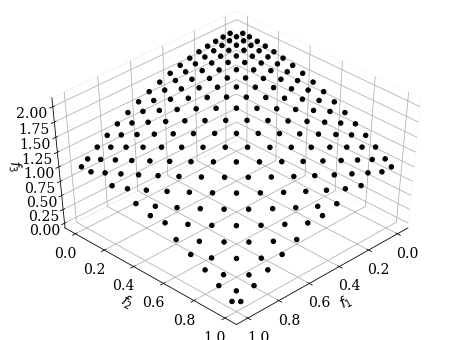

In [ ]:
plot = Scatter()
res_act.F = res_act.F[res_act.F[:,2]<10]
plot.add(res_act.F, color="black")
plot.show()

## **MCDM + Robustness**

In [ ]:
def O3T1_obj1(x):
  return x[:,0]

def O3T1_obj2(x):
  return x[:,1]

def O3T1_obj3(x, alpha, beta):
  h = 2-x[:,0]**2-x[:,1]**2
  g = 30 + x[:,2]**2 + x[:,3]**2 + x[:,4]**2 - 10*np.cos(4*ma.pi*x[:,2]) - 10*np.cos(4*ma.pi*x[:,3]) - 10*np.cos(4*ma.pi*x[:,4])
  S = alpha/(0.2 + x[:,0]) + beta*x[:,0]**8 + alpha/(0.2 + x[:,1]) + beta*x[:,1]**8
  return h + g*S

In [ ]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=5,
                         n_obj=3,
                         n_constr=1,
                         xl=np.array([0, 0, -1, -1, -1]),
                         xu=np.array([1, 1, 1, 1, 1]))

    def _evaluate(self, x, out, *args, **kwargs):
        alpha = 0.75; beta = 10;
        f1 = x[0]
        f2 = x[1]
        h = 2-x[0]**2-x[1]**2
        g = 30 + x[2]**2 + x[3]**2 + x[4]**2 - 10*np.cos(4*ma.pi*x[2]) - 10*np.cos(4*ma.pi*x[3]) - 10*np.cos(4*ma.pi*x[4])
        S = alpha/(0.2 + x[0]) + beta*x[0]**8 + alpha/(0.2 + x[1]) + beta*x[1]**8
        f3 = h + g*S

        H = 50; delta = 0.01; delta1 = 2*delta;
        lb = x - [delta, delta, delta1, delta1, delta1]
        ub = x + [delta, delta, delta1, delta1, delta1]
        sampler = qmc.LatinHypercube(d=5)
        sample = sampler.random(n=50)
        xe = qmc.scale(sample, lb, ub)

        f1_e = np.mean(O3T1_obj1(xe))
        f2_e = np.mean(O3T1_obj2(xe))
        f3_e = np.mean(O3T1_obj3(xe, 0.75, 10))

        g1 = np.linalg.norm(np.array([f1,f2,f3])-np.array([f1_e,f2_e,f3_e]))/np.linalg.norm(np.array([f1,f2,f3])) -  0.5

        out["F"] = [f1, f2, f3]
        out["G"] = [g1]

problem1 = MyProblem()

In [ ]:
# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=25)

# create the algorithm object
algorithm = NSGA3(pop_size=500, ref_dirs=ref_dirs)
#algorithm = NSGA2(pop_size=200)
res1 = minimize(problem1,
               algorithm,
               ("n_gen", 500),
               verbose=True,
               seed=1)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      500 |     32 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |     1000 |     37 |  0.000000E+00 |  0.000000E+00 |  0.0046879159 |         ideal
     3 |     1500 |     22 |  0.000000E+00 |  0.000000E+00 |  0.0381312207 |         ideal
     4 |     2000 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0097764425 |         ideal
     5 |     2500 |     34 |  0.000000E+00 |  0.000000E+00 |  0.0082886041 |         ideal
     6 |     3000 |     30 |  0.000000E+00 |  0.000000E+00 |  0.0100970807 |         ideal
     7 |     3500 |     26 |  0.000000E+00 |  0.000000E+00 |  0.4473505331 |         nadir
     8 |     4000 |     25 |  0.000000E+00 |  0.000000E+00 |  0.4166288205 |         nadir
     9 |     4500 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0053347647 |         ideal
    10 |     5000 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0041818137 |         ideal

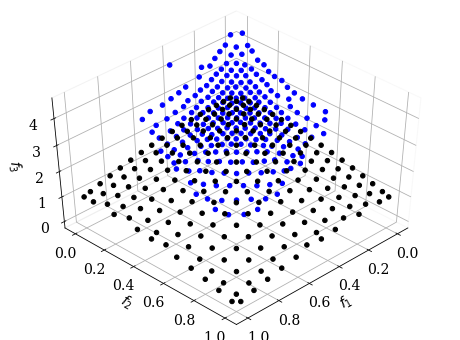

In [ ]:
plot = Scatter()
res1.F = res1.F[res1.F[:,2]<10.0]
plot.add(res_act.F, color="black")
plot.add(res1.F, color="blue")
plot.show()

## **R-NSGA-III based Robust MCDM**

In [ ]:
ref_points = np.array([[0.25, 0.25, 8.0], [0.25, 1.0, 6.0], [1.0, 0.25, 6.0], [1.0, 1.0, 1.5]]) #  , [0.75, 0.75, 2.0]
# ref_points = np.array([[1.0, 1.0, 1.5], [0.2, 0.2, 5.0]])

algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=10,
    mu=0.05)

res_RNSGAIIIa = minimize(problem1,
               algorithm=algorithm,
               termination=('n_gen', 2500),
               extreme_points_as_reference_points=True,
               seed=1, pf = res1.F,
               verbose=False)

In [ ]:
ref_points = np.array([[0.25, 0.25, 8.0], [0.25, 1.0, 6.0], [1.0, 0.25, 6.0], [1.0, 1.0, 1.5]]) #  , [0.75, 0.75, 2.0]
#ref_points = np.array([[1.0, 1.0, 1.5], [0.2, 0.2, 5.0]])

algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=10,
    mu=0.05)

res_RNSGAIIIb = minimize(problem,
               algorithm=algorithm,
               termination=('n_gen', 2500),
               extreme_points_as_reference_points=True,
               seed=1, pf = res_act.F,
               verbose=False)

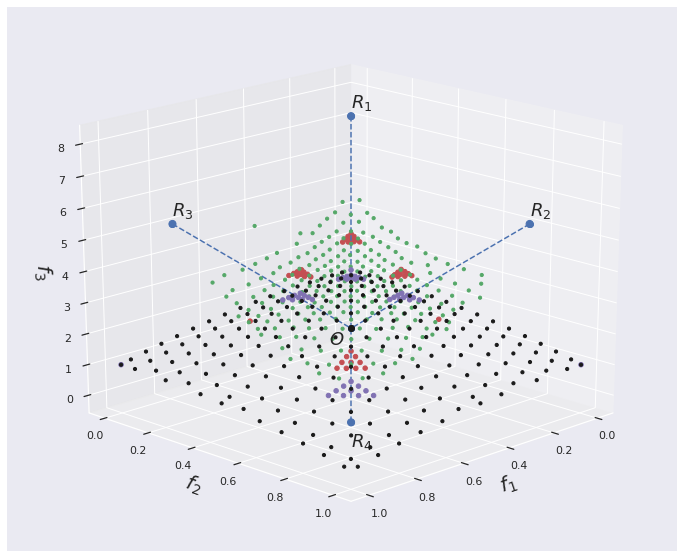

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

fig = plt.figure(figsize = (12, 10))
ax = plt.axes(projection ="3d")

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

ref_points = np.array([[0.25, 0.25, 8.0], [0.25, 1.0, 6.0], [1.0, 0.25, 6.0], [1.0, 1.0, 1.5]])
#ref_points = np.array([[1.0, 1.0, 1.5], [0.2, 0.2, 5.0]])
res_RNSGAIIIa.F = res_RNSGAIIIa.F[res_RNSGAIIIa.F[:,2]<5]
# res_RNSGAIIIa.F = res_RNSGAIIIa.F[res_RNSGAIIIa.F[:,2]>7]

ax.scatter(res_act.F[:, 0], res_act.F[:, 1], res_act.F[:, 2], s=10, facecolors='k', edgecolors='k', alpha = 1.0)
ax.scatter(res_RNSGAIIIb.F[:, 0], res_RNSGAIIIb.F[:, 1],res_RNSGAIIIb.F[:, 2],  s=20, facecolors='m', edgecolors='m', alpha = 1.0)
ax.scatter(res_RNSGAIIIa.F[:, 0], res_RNSGAIIIa.F[:, 1],res_RNSGAIIIa.F[:, 2],  s=20, facecolors='r', edgecolors='r', alpha = 1.0)
ax.scatter(res1.F[:, 0], res1.F[:, 1], res1.F[:, 2], s=10, facecolors='g', edgecolors='g', alpha = 1.0)
ax.scatter(ref_points[:, 0], ref_points[:, 1], ref_points[:, 2], s=50, facecolors='b', edgecolors='b', alpha = 1.0)
# ax.legend(["Original PF", "MCDM Orig Solns", "MCDM Rob Solns", "Rob Front $\eta$ = 0.05", "Ref Points"], loc ="upper right",fontsize=14)

ax.plot([0.25, 0], [0.25, 0], [8.0, 0], 'bo', linestyle="--")
ax.plot([0.25, 0], [1.0, 0], [6.0, 0], 'bo', linestyle="--")
ax.plot([1.0, 0], [0.25, 0], [6.0, 0], 'bo', linestyle="--")
ax.plot([1.0, 0], [1.0, 0], [1.5, 0], 'bo', linestyle="--")
ax.plot([0], [0], [0], 'ko', linestyle="--")
ax.text(0.25, 0.25, 8.25, "$R_1$",fontsize=18)
ax.text(0.25, 1.0, 6.25, "$R_2$",fontsize=18)
ax.text(1.0, 0.25, 6.25, "$R_3$",fontsize=18)
ax.text(1.0, 1.0, 0.75, "$R_4$",fontsize=18)
ax.text(-0.045, -0.15, -1.0, "$O$",fontsize=18)


ax.set_xlabel('$f_1$',fontsize=20)
ax.set_ylabel('$f_2$',fontsize=20)
ax.set_zlabel('$f_3$',fontsize=20)

# plt.title("Robust R-NSGA-III",fontsize=20)
plt.grid(color='k', linestyle='--', linewidth=1, alpha = 0.0)

ax.view_init(20, 45)
plt.draw()
#plt.savefig("T3_figure.png", transparent=True)

In [ ]:
max(res_RNSGAIIIa.F[:,2])

5.015521567150382

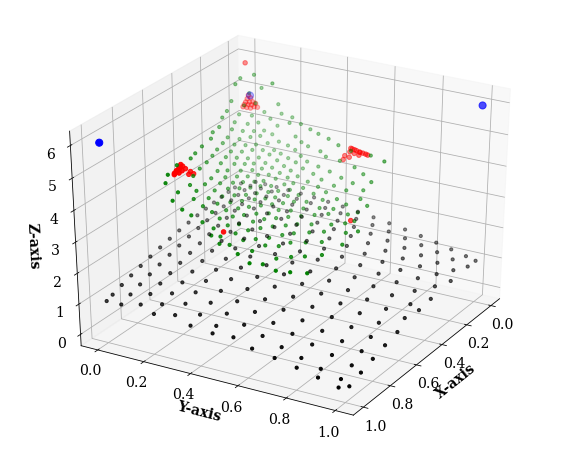

In [ ]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np

# Creating figure
fig = plt.figure(figsize = (10, 8))
ax = plt.axes(projection ="3d")

# Add x, and y gridlines for the figure
ax.grid(b = True, color ='blue',linestyle ='-.', linewidth = 0.5)

# Creating the 3D plot
ax.scatter3D(res_act.F[:, 0], res_act.F[:, 1], res_act.F[:, 2], s=10, facecolors='k', edgecolors='k')
ax.scatter3D(res1.F[:, 0], res1.F[:, 1], res1.F[:, 2], s=10, facecolors='g', edgecolors='g')
ax.scatter3D(res_RNSGAIIIa.F[:, 0], res_RNSGAIIIa.F[:, 1],res_RNSGAIIIa.F[:, 2],  s=20, facecolors='r', edgecolors='r')
ax.scatter3D(ref_points[:, 0], ref_points[:, 1], ref_points[:, 2], s=50, facecolors='b', edgecolors='b')

#ax.legend(["Original PF", "Robust Front", "MCDM Solns D", "Ref Points"], loc ="upper right",fontsize=16)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# display the plot
ax.view_init(30, 30)
plt.draw()

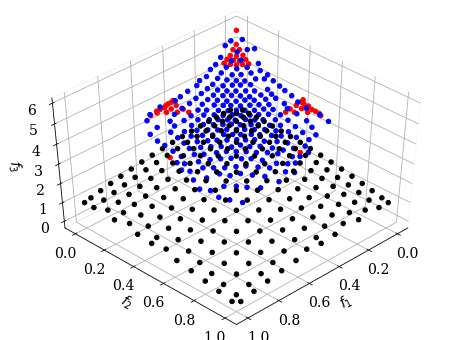

In [ ]:
plot = Scatter()
res1.F = res1.F[res1.F[:,2]<10.0]
#res_RNSGAIIIa.F = res_RNSGAIIIa.F[res_RNSGAIIIa.F[:,2]<2.4]
plot.add(res_act.F, color="black")
plot.add(res1.F, color="blue")
plot.add(res_RNSGAIIIa.F, color="red")
plot.show()

In [ ]:
#res_RNSGAIIIa.F

# **5-Objective River Pollution Problem**

In [ ]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=5,
                         n_constr=0,
                         xl=np.array([0.3, 0.3]),
                         xu=np.array([1, 1]))

    def _evaluate(self, x, out, *args, **kwargs):

        f1 = -(4.07 + 2.27 * x[0]);
        f2 = -(2.60 + 0.03*x[0] + 0.02*x[1] + 0.01 / (1.39 - x[0]**2) + 0.30 / (1.39 - x[1]**2))
        f3 = -(8.21 - 0.71 / (1.09 - x[0]**2))
        f4 = -(0.96 - 0.96 / (1.09 - x[1]**2))
        f5 = np.max([abs(x[0] - 0.65), abs(x[1] - 0.65)])

        out["F"] = [f1, f2, f3, f4, f5]
        #out["G"] = [g1]

problem = MyProblem()

In [ ]:
ref_dirs = get_reference_directions("das-dennis", 5, n_partitions=20)

# create the algorithm object
algorithm = NSGA3(pop_size=11000, ref_dirs=ref_dirs)
# algorithm = NSGA2(pop_size=250)

res = minimize(problem,
               algorithm,
               ("n_gen", 20),
               verbose=True,
               seed=1)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |    11000 |    227 |             - |             -
     2 |    22000 |    237 |  0.0109413949 |         ideal
     3 |    33000 |    235 |  0.0140080250 |         ideal
     4 |    44000 |    239 |  0.0061223812 |         nadir
     5 |    55000 |    238 |  0.0067052282 |         ideal
     6 |    66000 |    239 |  0.0111203943 |         ideal
     7 |    77000 |    240 |  0.0025005701 |             f
     8 |    88000 |    241 |  0.0029467069 |             f
     9 |    99000 |    238 |  0.0081448741 |         ideal
    10 |   110000 |    240 |  0.0019837200 |             f
    11 |   121000 |    242 |  0.0029362211 |             f
    12 |   132000 |    242 |  0.0012759149 |             f
    13 |   143000 |    243 |  0.0018911402 |             f
    14 |   154000 |    244 |  0.0021017039 |             f
    15 |   165000 |    242 |  0.0023294734 |             f
    16 |   176000 |    240 |  0.0025049922 |         ide

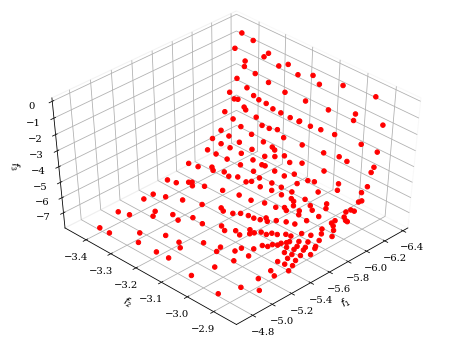

In [ ]:
plot = Scatter()
plot.add(res.F[:,0:3], color="red")
plot.show()

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
River_orig = pd.DataFrame(np.concatenate((res.F,res.X),axis=1))

River_orig.to_csv("River_orig.csv")
files.download("River_orig.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **MCDM + Robustness**

In [ ]:
def Water_obj1(x):
  return -(4.07 + 2.27 * x[:,0])

def Water_obj2(x):
  return -(2.60 + 0.03*x[:,0] + 0.02*x[:,1] + 0.01 / (1.39 - x[:,0]**2) + 0.30 / (1.39 - x[:,1]**2))

def Water_obj3(x):
  return -(8.21 - 0.71 / (1.09 - x[:,0]**2))

def Water_obj4(x):
  return -(0.96 - 0.96 / (1.09 - x[:,1]**2))

def Water_obj5(x):
  return np.max([abs(x[:,0] - 0.65), abs(x[:,1] - 0.65)])

In [ ]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=5,
                         n_constr=1,
                         xl=np.array([0.3, 0.3]),
                         xu=np.array([1, 1]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = -(4.07 + 2.27 * x[0]);
        f2 = -(2.60 + 0.03*x[0] + 0.02*x[1] + 0.01 / (1.39 - x[0]**2) + 0.30 / (1.39 - x[1]**2))
        f3 = -(8.21 - 0.71 / (1.09 - x[0]**2))
        f4 = -(0.96 - 0.96 / (1.09 - x[1]**2))
        f5 = np.max([abs(x[0] - 0.65), abs(x[1] - 0.65)])

        delta = 0.025
        lb = x - [delta, delta]
        ub = x + [delta, delta]
        sampler = qmc.LatinHypercube(d=2)
        sample = sampler.random(n=100)
        xe = qmc.scale(sample, lb, ub)

        f1_e = np.mean(Water_obj1(xe))
        f2_e = np.mean(Water_obj2(xe))
        f3_e = np.mean(Water_obj3(xe))
        f4_e = np.mean(Water_obj4(xe))
        f5_e = np.mean(Water_obj5(xe))

        g1 = np.linalg.norm(np.array([f1,f2,f3,f4,f5])-np.array([f1_e,f2_e,f3_e,f4_e,f5_e]))/np.linalg.norm(np.array([f1,f2,f3,f4,f5])) -  0.01
        out["F"] = [f1, f2, f3, f4, f5]
        out["G"] = [g1]

problem1 = MyProblem()

In [ ]:
ref_dirs = get_reference_directions("das-dennis", 5, n_partitions=20)

# create the algorithm object
algorithm = NSGA3(pop_size=11000, ref_dirs=ref_dirs)
#algorithm = NSGA2(pop_size=1000)

res1 = minimize(problem1,
               algorithm,
               ("n_gen", 10),
               verbose=True,
               seed=1)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |    11000 |    236 |  0.000000E+00 |  0.0041872470 |             - |             -
     2 |    22000 |    249 |  0.000000E+00 |  0.000000E+00 |  0.0074133027 |         ideal
     3 |    33000 |    249 |  0.000000E+00 |  0.000000E+00 |  0.0056591861 |         nadir
     4 |    44000 |    249 |  0.000000E+00 |  0.000000E+00 |  0.0041581739 |             f
     5 |    55000 |    253 |  0.000000E+00 |  0.000000E+00 |  0.0044107530 |         nadir
     6 |    66000 |    253 |  0.000000E+00 |  0.000000E+00 |  0.0025390438 |         ideal
     7 |    77000 |    254 |  0.000000E+00 |  0.000000E+00 |  0.0026141902 |             f
     8 |    88000 |    256 |  0.000000E+00 |  0.000000E+00 |  0.0020776342 |             f
     9 |    99000 |    253 |  0.000000E+00 |  0.000000E+00 |  0.0028283609 |             f
    10 |   110000 |    254 |  0.000000E+00 |  0.000000E+00 |  0.0015998860 |             f

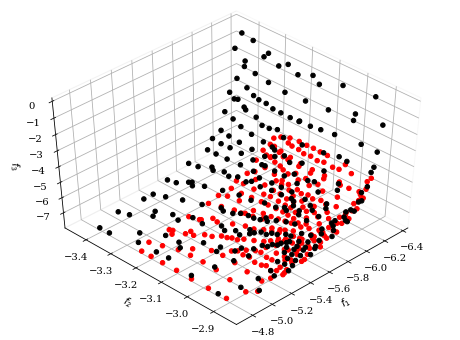

In [ ]:
plot = Scatter()
plot.add(res.F[:,0:3], color="black")
plot.add(res1.F[:,0:3], color="red")
plot.show()

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
River_rob = pd.DataFrame(np.concatenate((res1.F,res1.X),axis=1))

River_rob.to_csv("River_rob.csv")
files.download("River_rob.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **R-NSGA-III based MCDM**

In [ ]:
ref_points = np.array([[-6.0, -3.4, 0.0, 10, 0.25]]) #

algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=1001,
    mu=0.05)

res_RNSGAIII = minimize(problem1,
               algorithm=algorithm,
               termination=('n_gen', 100),
               extreme_points_as_reference_points=True,
               seed=1, pf = res1.F,
               verbose=False)

In [ ]:
ref_points = np.array([[-6.0, -3.4, 0.0, 10, 0.25]]) #

algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=1001,
    mu=0.05)

res_RNSGAIIIa = minimize(problem,
               algorithm=algorithm,
               termination=('n_gen', 100),
               extreme_points_as_reference_points=True,
               seed=1, pf = res.F,
               verbose=False)

<Figure size 864x720 with 0 Axes>

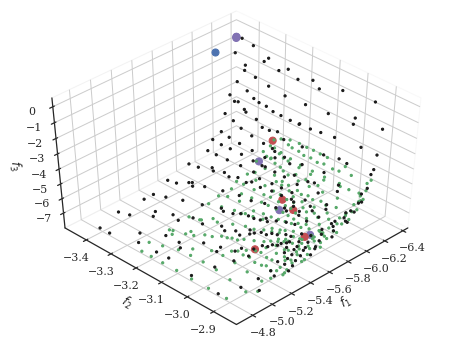

In [ ]:
plot = Scatter()
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
plt.rcParams['font.size'] = 14
#res1.F = res1.F[res1.F[:,1]<0.15]
plot.add(res.F[:,[0,1,2]],  s=5, facecolors='k', edgecolors='k')
plot.add(res_RNSGAIIIa.F[:,[0,1,2]], s=50, facecolors='m', edgecolors='m')
plot.add(res1.F[:,[0,1,2]], s=5, facecolors='g', edgecolors='g')
plot.add(res_RNSGAIII.F[:,[0,1,2]], s=50, facecolors='r', edgecolors='r')
plot.add(ref_points[:,[0,1,2]], s=50, facecolors='b', edgecolors='b')
plot.show()

In [ ]:
res_RNSGAIIIa.X

array([[0.72246326, 0.57752822],
       [0.87245182, 0.9380231 ],
       [0.99911587, 0.99999986],
       [0.75300596, 0.82110313],
       [0.99954921, 0.99978333],
       [0.99951106, 0.99997838]])

<Figure size 864x720 with 0 Axes>

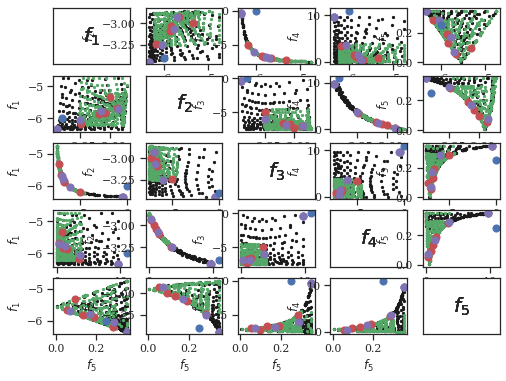

In [ ]:
plot = Scatter()
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
plt.rcParams['font.size'] = 14
#res1.F = res1.F[res1.F[:,1]<0.15]
plot.add(res.F,  s=5, facecolors='k', edgecolors='k')
plot.add(res1.F, s=5, facecolors='g', edgecolors='g')
plot.add(res_RNSGAIII.F, s=50, facecolors='r', edgecolors='r')
plot.add(res_RNSGAIIIa.F, s=50, facecolors='m', edgecolors='m')
plot.add(ref_points, s=50, facecolors='b', edgecolors='b')
plot.show()

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
River_MCDM = pd.DataFrame(np.concatenate((res_RNSGAIII.F,res_RNSGAIII.X),axis=1))

River_MCDM.to_csv("River_MCDM.csv")
files.download("River_MCDM.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving River_MCDM.xlsx to River_MCDM (5).xlsx


In [ ]:
import io
import pandas as pd
df = pd.read_excel(io.BytesIO(uploaded['River_MCDM.xlsx']))
df.head()

,F1,F2,F3,F4,F5,X1,X2,Category
0,-4.920843,-2.903025,-7.462246,0.241574,0.275179,0.374821,0.539489,0.0
1,-5.997897,-2.969443,-6.284316,0.516622,0.199294,0.849294,0.663225,0.0
2,-6.328705,-3.127294,-1.104796,1.715198,0.345024,0.995024,0.855072,0.0
3,-5.681100,-2.949955,-6.998964,0.441987,0.059736,0.709736,0.636598,0.0
4,-6.303985,-3.166699,-2.365390,2.185818,0.334134,0.984134,0.885908,0.0


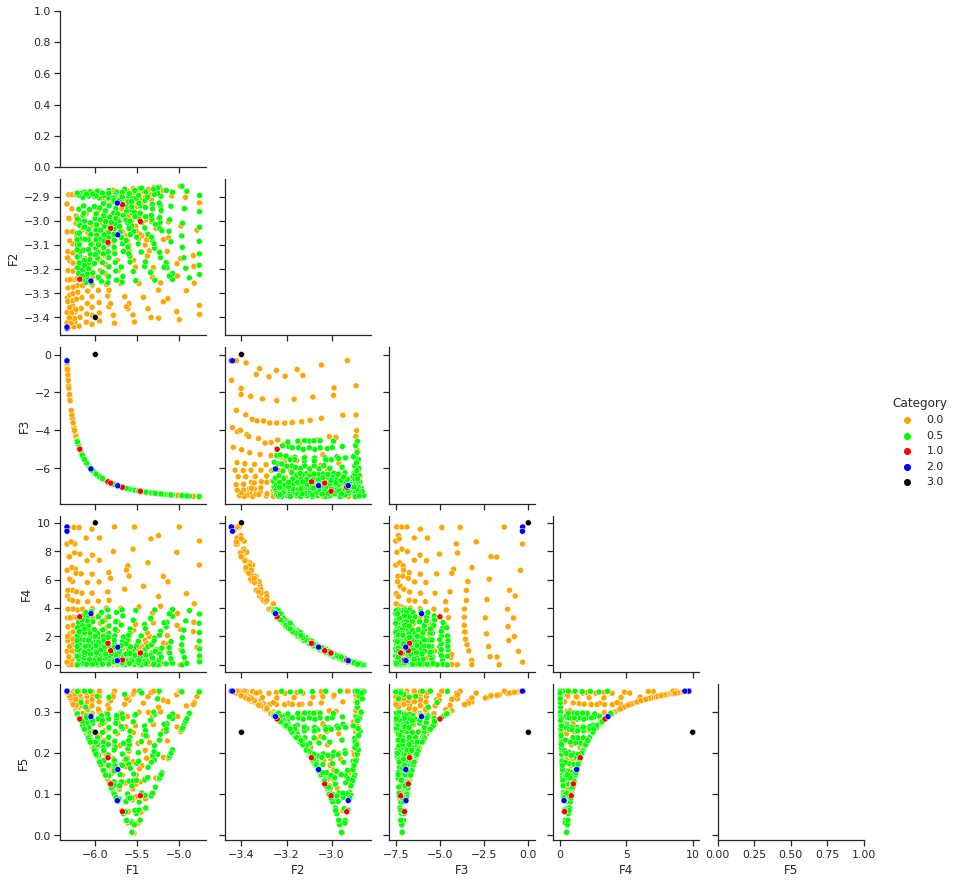

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")
df1 = df[['F1','F2','F3','F4','F5','Category']]
sns.pairplot(df1, diag_kind = "None", hue="Category", palette= ['#FFA500','#00FF00', '#FF0000', '#0000FF','#000000'], corner="False") # #D3D3D3

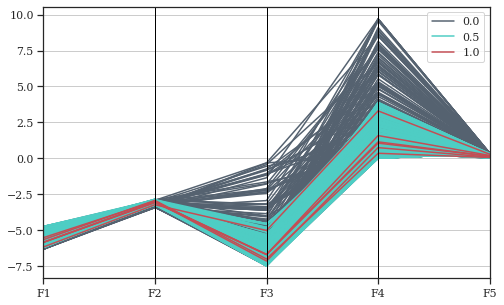

In [ ]:
plot = Scatter()
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))

pd.plotting.parallel_coordinates(
    df1, 'Category', color=('#556270', '#4ECDC4', '#C44D54')
)

# **8-Objective Problem**

In [ ]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=10,
                         n_obj=8,
                         n_constr=0,
                         xl=np.array([0, 0, 0, 0, 0, 0, 0, 0, -1, -1]),
                         xu=np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[0]
        f2 = x[1]
        f3 = x[2]
        f4 = x[3]
        f5 = x[4]
        f6 = x[5]
        f7 = x[6]
        h = 2 - 0.8*ma.exp(-((x[7] -0.35)/0.25)**2) - ma.exp(-((x[7] -0.85)/0.03)**2)
        g =  20 + x[8]**2 + x[9]**2 - 10*np.cos(4*ma.pi*x[8]) - 10*np.cos(4*ma.pi*x[9])
        S = 10 - x[0]**0.5 - x[1]**0.5 - x[2]**0.5 - x[3]**0.5 - x[4]**0.5 - x[5]**0.5 - x[6]**0.5
        f8 = h*(g + S)

        out["F"] = [f1, f2, f3, f4, f5, f6, f7, f8]

problem = MyProblem()

In [ ]:
# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 8, n_partitions=6)

algorithm = NSGA3(pop_size=1750, ref_dirs=ref_dirs)
# algorithm = NSGA2(pop_size=200)
res_act = minimize(problem,
               algorithm,
               ("n_gen", 200),
               verbose=True,
               seed=1)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |     1750 |    219 |             - |             -
     2 |     3500 |    274 |  0.0046918880 |         ideal
     3 |     5250 |    294 |  0.0219240383 |         ideal
     4 |     7000 |    332 |  0.0119011530 |         ideal
     5 |     8750 |    421 |  0.0073008623 |         ideal
     6 |    10500 |    310 |  0.0095529790 |         ideal
     7 |    12250 |    279 |  0.0273120935 |         ideal
     8 |    14000 |    204 |  0.0313558257 |         ideal
     9 |    15750 |    242 |  0.0113403513 |         ideal
    10 |    17500 |    281 |  0.0137209221 |         ideal
    11 |    19250 |    300 |  0.1073402634 |         nadir
    12 |    21000 |    376 |  0.0781002861 |         nadir
    13 |    22750 |    397 |  0.2855323444 |         nadir
    14 |    24500 |    443 |  0.0121300077 |         ideal
    15 |    26250 |    442 |  0.0098842201 |         ideal
    16 |    28000 |    426 |  0.0097707329 |         ide

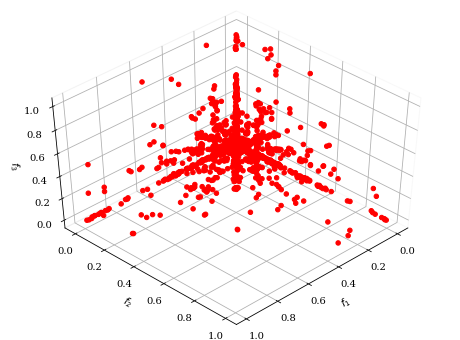

In [ ]:
plot = Scatter()
# res_act.F = res_act.F[res_act.F[:,3]<3.5]
plot.add(res_act.F[:,[0,1,4]], color="red")
plot.show()

## **MCDM + Robustness**

In [ ]:
def O8T1_obj1(x):
  return x[:,0]

def O8T1_obj2(x):
  return x[:,1]

def O8T1_obj3(x):
  return x[:,2]

def O8T1_obj4(x):
  return x[:,3]

def O8T1_obj5(x):
  return x[:,4]

def O8T1_obj6(x):
  return x[:,5]

def O8T1_obj7(x):
  return x[:,6]

def O8T1_obj8(x):
  h = 2 - 0.8*np.exp(-((x[:,7] -0.35)/0.25)**2) - np.exp(-((x[:,7] -0.85)/0.03)**2)
  g = 20 + x[:,8]**2 + x[:,9]**2 - 10*np.cos(4*ma.pi*x[:,8]) - 10*np.cos(4*ma.pi*x[:,9])
  S = 10 - np.max(x[:,0],0)**0.5 - np.max(x[:,1],0)**0.5 - np.max(x[:,2],0)**0.5 - np.max(x[:,3],0)**0.5 - np.max(x[:,4],0)**0.5 - np.max(x[:,5],0)**0.5 - np.max(x[:,6],0)**0.5
  return h*(g + S)

In [ ]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=10,
                         n_obj=8,
                         n_constr=1,
                         xl=np.array([0, 0, 0, 0, 0, 0, 0, 0, -1, -1]),
                         xu=np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

    def _evaluate(self, x, out, *args, **kwargs):

        f1 = x[0]
        f2 = x[1]
        f3 = x[2]
        f4 = x[3]
        f5 = x[4]
        f6 = x[5]
        f7 = x[6]
        h = 2 - 0.8*ma.exp(-((x[7] -0.35)/0.25)**2) - ma.exp(-((x[7] -0.85)/0.03)**2)
        g =  20 + x[8]**2 + x[9]**2 - 10*np.cos(4*ma.pi*x[8]) - 10*np.cos(4*ma.pi*x[9])
        S = 10 - x[0]**0.5 - x[1]**0.5 - x[2]**0.5 - x[3]**0.5 - x[4]**0.5 - x[5]**0.5 - x[6]**0.5
        f8 = h*(g + S)

        delta = 0.075; delta1 = 2*delta;
        lb = x - [delta, delta, delta, delta, delta, delta, delta, delta, delta1, delta1]
        ub = x + [delta, delta, delta, delta, delta, delta, delta, delta, delta1, delta1]
        sampler = qmc.LatinHypercube(d=10)
        sample = sampler.random(n=100)
        xe = qmc.scale(sample, lb, ub)

        f1_e = np.mean(O8T1_obj1(xe))
        f2_e = np.mean(O8T1_obj2(xe))
        f3_e = np.mean(O8T1_obj3(xe))
        f4_e = np.mean(O8T1_obj4(xe))
        f5_e = np.mean(O8T1_obj5(xe))
        f6_e = np.mean(O8T1_obj6(xe))
        f7_e = np.mean(O8T1_obj7(xe))
        f8_e = np.mean(O8T1_obj8(xe))

        g1 = np.linalg.norm(np.array([f1,f2,f3,f4,f5,f6,f7,f8])-np.array([f1_e,f2_e,f3_e,f4_e,f5_e,f6_e,f7_e,f8_e]))/np.linalg.norm(np.array([f1,f2,f3,f4,f5,f6,f7,f8])) -  1.5

        out["F"] = [f1, f2, f3, f4, f5, f6, f7, f8]
        out["G"] = [g1]

problem1 = MyProblem()

In [ ]:
# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 8, n_partitions=6)

algorithm = NSGA3(pop_size=1750, ref_dirs=ref_dirs)
# algorithm = NSGA2(pop_size=200)
res1 = minimize(problem1,
               algorithm,
               ("n_gen", 100),
               verbose=True,
               seed=1)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |     1750 |    213 |  0.000000E+00 |  0.0035903643 |             - |             -
     2 |     3500 |    249 |  0.000000E+00 |  0.000000E+00 |  0.0047736144 |         ideal
     3 |     5250 |    297 |  0.000000E+00 |  0.000000E+00 |  0.0729188352 |         nadir
     4 |     7000 |    358 |  0.000000E+00 |  0.000000E+00 |  0.0069724346 |         ideal
     5 |     8750 |    414 |  0.000000E+00 |  0.000000E+00 |  0.0029497970 |         ideal
     6 |    10500 |    436 |  0.000000E+00 |  0.000000E+00 |  0.1026931442 |         nadir
     7 |    12250 |    406 |  0.000000E+00 |  0.000000E+00 |  0.0048934310 |         ideal
     8 |    14000 |    339 |  0.000000E+00 |  0.000000E+00 |  0.0035856565 |         ideal
     9 |    15750 |    318 |  0.000000E+00 |  0.000000E+00 |  0.0037496536 |         ideal
    10 |    17500 |    257 |  0.000000E+00 |  0.000000E+00 |  0.6133089325 |         nadir

## **R-NSGA-III Robustness**

In [ ]:
ref_points = np.array([[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 40.0]]) #  , [0.75, 0.75, 2.0]
#ref_points = np.array([[1.0, 1.0, 1.5], [0.2, 0.2, 5.0]])

algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=120,
    mu=0.05)

res_RNSGAIIIa = minimize(problem1,
               algorithm=algorithm,
               termination=('n_gen', 2000),
               extreme_points_as_reference_points=True,
               seed=1,
               verbose=False)

In [ ]:
ref_points = np.array([[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 40.0]]) #  , [0.75, 0.75, 2.0]
#ref_points = np.array([[1.0, 1.0, 1.5], [0.2, 0.2, 5.0]])

algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=120,
    mu=0.05)

res_RNSGAIIIb = minimize(problem,
               algorithm=algorithm,
               termination=('n_gen', 2000),
               extreme_points_as_reference_points=True,
               seed=1, pf = res_act.F,
               verbose=False)

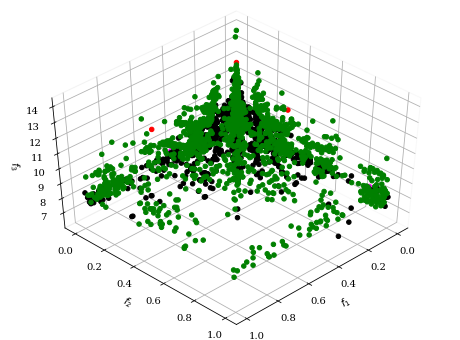

In [ ]:
plot = Scatter()
res_act.F = res_act.F[res_act.F[:,7]<20]
res1.F = res1.F[res1.F[:,7]<30]
res_RNSGAIIIa.F = res_RNSGAIIIa.F[res_RNSGAIIIa.F[:,7]<20]
res_RNSGAIIIb.F = res_RNSGAIIIb.F[res_RNSGAIIIb.F[:,7]<15]
plot.add(res_act.F[:,[0,1,7]], color="black")
plot.add(res_RNSGAIIIb.F[:,[0,1,7]], color="magenta")
plot.add(res1.F[:,[0,1,7]], color="green")
plot.add(res_RNSGAIIIa.F[:,[0,1,7]], color="red")

plot.show()

In [ ]:
min(res_RNSGAIIIa.F[:,7])-max(res_act.F[:,7])


-1.7597565408811047

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
res1.X = res1.X[np.where(res1.F[:,7]<30)]
RT4O8 = pd.DataFrame(np.concatenate((res1.F,res1.X),axis=1))
RT4O8.to_csv("RT4O8.csv")
files.download("RT4O8.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
res_RNSGAIIIa.X = res_RNSGAIIIa.X[np.where(res_RNSGAIIIa.F[:,7]<20)]
RMCDM_T4O8 = pd.DataFrame(np.concatenate((res_RNSGAIIIa.F,res_RNSGAIIIa.X),axis=1))
RMCDM_T4O8.to_csv("RMCDM_T4O8.csv")
files.download("RMCDM_T4O8.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
res_RNSGAIIIb.X = res_RNSGAIIIb.X[np.where(res_RNSGAIIIb.F[:,7]<20)]
MCDM_T4O8 = pd.DataFrame(np.concatenate((res_RNSGAIIIb.F,res_RNSGAIIIb.X),axis=1))
MCDM_T4O8.to_csv("MCDM_T4O8.csv")
files.download("MCDM_T4O8.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving T4_Obj_8_MCDM.xlsx to T4_Obj_8_MCDM (1).xlsx


In [ ]:
import io
import pandas as pd
import numpy as np
df = pd.read_excel(io.BytesIO(uploaded['T4_Obj_8_MCDM.xlsx']))
df.describe()

,F1,F2,F3,F4,F5,F6,F7,F8,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Category
count,3.486000e+03,3486.000000,3.486000e+03,3486.000000,3486.000000,3.486000e+03,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3485.000000,3486.000000,3486.000000
mean,9.574023e-02,0.093228,9.435785e-02,0.084415,0.089595,8.898018e-02,0.097081,9.252888,0.095274,0.092777,0.093966,0.084065,0.089349,0.088881,0.096781,0.608148,-0.004565,-0.002538,0.615605
std,1.465145e-01,0.141001,1.478731e-01,0.135139,0.142043,1.382508e-01,0.150473,1.271682,0.145776,0.140220,0.147129,0.134645,0.142052,0.138496,0.149965,0.251460,0.056491,0.048782,0.713653
min,5.845142e-07,0.000008,8.989094e-07,0.000005,0.000007,4.114630e-07,0.000002,6.479797,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.525508,-0.960834,0.000000
25%,3.955113e-03,0.003725,3.335951e-03,0.003383,0.003540,3.432924e-03,0.003849,8.103515,0.003904,0.003692,0.003311,0.003340,0.003534,0.003418,0.003839,0.349049,-0.002959,-0.004030,0.000000
50%,2.917588e-02,0.025471,2.387364e-02,0.017988,0.022753,2.190718e-02,0.028077,9.247251,0.028039,0.024865,0.022757,0.017246,0.022003,0.020595,0.026687,0.847506,-0.000319,-0.000933,1.000000
75%,1.365396e-01,0.140249,1.345903e-01,0.122474,0.125550,1.255141e-01,0.137905,10.074285,0.136394,0.140225,0.134590,0.122474,0.125275,0.125514,0.137905,0.849910,0.001513,0.001412,1.000000
max,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000,40.000000,0.990657,0.996144,0.990056,0.990834,0.998908,0.994887,0.985532,0.910991,0.508604,0.501522,4.000000


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
# data=data.sort_values(by=['x3'])
# scaler = MinMaxScaler()
# df=scaler.fit_transform(data.values)
# df=pd.DataFrame(df)

fig = px.parallel_coordinates(df,color='Category',
                              dimensions=['F1','F2','F3','F4','F5','F6','F7','F8'], color_continuous_scale=["gray","green","magenta","red","black"],
                              color_continuous_midpoint=2)
fig.update_layout(
    font_color="black",
    title_font_family="Times New Roman",
    title_font_color="red",
    legend_title_font_color="green",
    font=dict(
        family="Times New Roman",
        size=22,
        color="black")
)


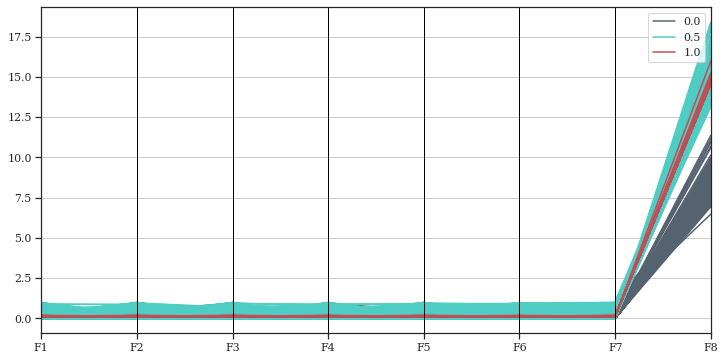

In [ ]:
plot = Scatter()
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
df1 = df[['F1','F2','F3','F4','F5','F6','F7','F8','Category']]

#df1=(df1-df1.min())/(df1.max()-df1.min())

pd.plotting.parallel_coordinates(
    df1, 'Category', color=('#556270', '#4ECDC4', '#C44D54')
)